In [30]:
pip install pmdarima


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import pandas as pd
import numpy as np
df = pd.read_csv('weather1.csv',index_col='obstime',parse_dates=True)
df = df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (4898, 5)


,tempr,ap,ws,wd,rh
obstime,,,,,
2015-11-01 00:00:00,-12.52,973.92,29.30,86.38,43.13
2015-11-01 01:00:00,-11.88,973.54,26.00,87.63,44.22
2015-11-01 02:00:00,-10.60,973.14,24.80,86.27,43.35
2015-11-01 03:00:00,-9.46,972.51,23.96,87.77,43.95
2015-11-01 04:00:00,-7.80,971.80,20.90,72.77,44.03


<Axes: xlabel='obstime'>

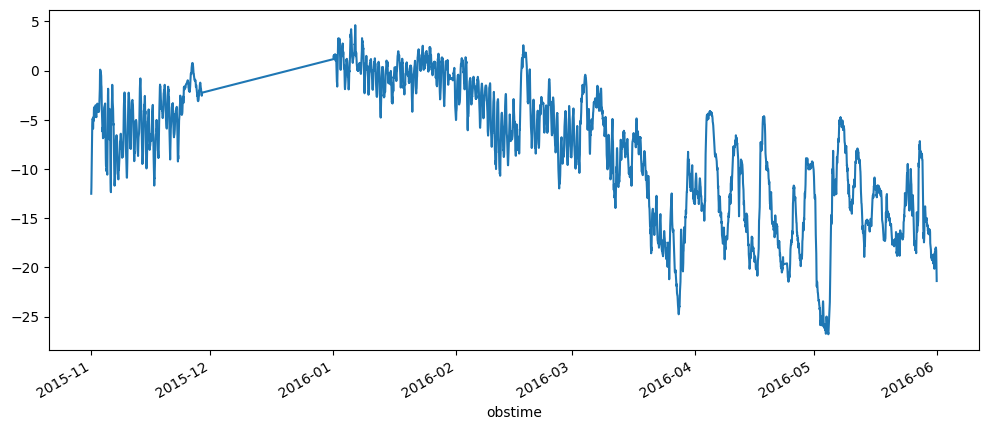

In [32]:
df['tempr'].plot(figsize=(12,5))

Now we will check for stationarity. Conditions for stationarity are:
1. Means and Variance should be constant
2. Timeseries should not have any repeating pattern or trends

We now gonna use 'Augmented Dickey-Fuller' test used for checking the stationarity of a time series.

P-value = Probablity value 
if p>0.5 : dataset not stationary
if p<0.5 :  dataset is stationary

If a time series does not exhibit autocorrelation (i.e., the values are independent of each other over time), simpler models like moving averages or basic statistical methods might be sufficient for analysis and forecasting.

In [33]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['tempr'] , autolag='AIC')
print("1. ADF :" , dftest[0])   # A more negative value generally indicates stronger evidence against the null hypothesis, suggesting that the data is stationary.
print("2. P-Value:" , dftest[1])
print("3. Num of Lags :" , dftest[2]) # 32 lags in a time series model  it means the model is using the past 32 values of the time series to predict or explain the present value.
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :" , dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ":", val)

1. ADF : -3.1530044744195496
2. P-Value: 0.022871278507630665
3. Num of Lags : 32
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 4865
5. Critical Values :
	 1% : -3.4316948620176393
	 5% : -2.862134279956787
	 10% : -2.5670863365651626


Figure Out Order For Arima Model(AR , I , MA)

AR=> used past value to make future prediction

I=> used to make dataset stationary

MA =>  uses past error to make future prediction

In [34]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [35]:
# auto_arima will generate different order and correspondinng AIC score. The goal is to reduce AIC score
stepwide_fit = auto_arima(df['tempr'],trace=True,
                          suppress_warnings=True)
stepwide_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6451.735, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7574.410, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6481.128, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6730.766, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7572.469, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6449.414, Time=2.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6563.179, Time=1.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6447.735, Time=1.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6449.541, Time=4.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6451.901, Time=1.64 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6445.753, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6728.803, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6479.150, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6447.558, Time=1.75 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4898
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3219.876
Date:                Fri, 23 Aug 2024   AIC                           6445.753
Time:                        12:45:44   BIC                           6465.242
Sample:                             0   HQIC                          6452.591
                               - 4898                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5999      0.017     35.451      0.000       0.567       0.633
ma.L1         -0.1919      0.018    -10.633      0.000      -0.227      -0.157
sigma2         0.2181      0.001    203.856      0.000       0.216       0.220
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            232869.09
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

What are orders here

ARIMA(p, d, q):

p: The number of lag observations included in the model (AutoRegressive part).

d: The number of times that the raw observations are differenced (Integrated part).

q: The size of the moving average window (Moving Average part).

The notation with [0] indicates there is no seasonal component (i.e., it's a non-seasonal ARIMA model).

eg: ARIMA(2,1,2): This model includes 2 autoregressive terms, 1 difference, and 2 moving average terms.

The AIC score takes into account how well the model fits the data. 

In [36]:
from statsmodels.tsa.arima.model import ARIMA
print(df.shape)
train=df.iloc[:30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(4898, 5)
(30, 5) (30, 5)


In [37]:
model = ARIMA(train['tempr'],order=(3,0,30))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  tempr   No. Observations:                   30
Model:                ARIMA(3, 0, 30)   Log Likelihood                 -14.009
Date:                Fri, 23 Aug 2024   AIC                             98.019
Time:                        12:45:47   BIC                            147.061
Sample:                             0   HQIC                           113.708
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5191     28.270     -0.231      0.818     -61.928      48.890
ar.L1          0.5555   1973.280      0.000      1.000   -3867.002    3868.113
ar.L2         -0.3362   2671.753     -0.000      1.000   -5236.876    5236.203
ar.L3          0.3584    859.191      0.000      1.000   -1683.625    1684.342
ma.L1          1.2127   7.33e+04   1.65e-05      1.000   -1.44e+05    1.44e+05
ma.L2          1.7471   2.41e+04   7.24e-05      1.000   -4.73e+04    4.73e+04
ma.L3          1.9584   6.87e+04   2.85e-05      1.000   -1.35e+05    1.35e+05
ma.L4          2.4034   3.09e+04   7.79e-05      1.000   -6.05e+04    6.05e+04
ma.L5          1.8488      2e+04   9.23e-05      1.000   -3.93e+04    3.93e+04
ma.L6          1.7631   2.68e+04   6.58e-05      1.000   -5.25e+04    5.25e+04
ma.L7          1.2513   2.74e+04   4.56e-05      1.000   -5.37e+04    5.37e+04
ma.L8          1.2335   6.42e+04   1.92e-05      1.000   -1.26e+05    1.26e+05
ma.L9          1.3313   1.89e+04   7.03e-05      1.000   -3.71e+04    3.71e+04
ma.L10         1.4677   1.33e+04      0.000      1.000    -2.6e+04     2.6e+04
ma.L11         1.8826   2.98e+04   6.32e-05      1.000   -5.84e+04    5.84e+04
ma.L12         1.7147   2.63e+04   6.52e-05      1.000   -5.15e+04    5.15e+04
ma.L13         1.8771   6.66e+04   2.82e-05      1.000   -1.31e+05    1.31e+05
ma.L14         2.2831   4.13e+04   5.53e-05      1.000   -8.09e+04    8.09e+04
ma.L15         1.8703   3.85e+04   4.86e-05      1.000   -7.54e+04    7.54e+04
ma.L16         1.3686   6.45e+04   2.12e-05      1.000   -1.26e+05    1.26e+05
ma.L17         1.4781   1.36e+04      0.000      1.000   -2.66e+04    2.66e+04
ma.L18         1.4720   1.53e+04   9.65e-05      1.000   -2.99e+04    2.99e+04
ma.L19         1.1683   9807.571      0.000      1.000   -1.92e+04    1.92e+04
ma.L20         1.3768   1.46e+04   9.43e-05      1.000   -2.86e+04    2.86e+04
ma.L21         1.5684   3972.864      0.000      1.000   -7785.101    7788.238
ma.L22         1.8511   4.52e+04    4.1e-05      1.000   -8.86e+04    8.86e+04
ma.L23         2.1076   1.79e+04      0.000      1.000    -3.5e+04     3.5e+04
ma.L24         1.7222   3.71e+04   4.64e-05      1.000   -7.28e+04    7.28e+04
ma.L25         1.6148   7774.962      0.000      1.000   -1.52e+04    1.52e+04
ma.L26         0.6058   5.99e+04   1.01e-05      1.000   -1.17e+05    1.17e+05
ma.L27         0.4194   2.13e+04   1.97e-05      1.000   -4.18e+04    4.18e+04
ma.L28        -0.0838   4.74e+04  -1.77e-06      1.000   -9.28e+04    9.28e+04
ma.L29        -0.2592   4.09e+04  -6.34e-06      1.000   -8.01e+04    8.01e+04
ma.L30        -0.5938   3913.865     -0.000      1.000   -7671.629    7670.442
sigma2         0.0426    186.596      0.000      1.000    -365.678     365.763
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.50   Prob(JB):                 

In [38]:
df.__len__

<bound method DataFrame.__len__ of                      tempr      ap     ws     wd     rh
obstime                                                
2015-11-01 00:00:00 -12.52  973.92  29.30  86.38  43.13
2015-11-01 01:00:00 -11.88  973.54  26.00  87.63  44.22
2015-11-01 02:00:00 -10.60  973.14  24.80  86.27  43.35
2015-11-01 03:00:00  -9.46  972.51  23.96  87.77  43.95
2015-11-01 04:00:00  -7.80  971.80  20.90  72.77  44.03
...                    ...     ...    ...    ...    ...
2016-05-31 19:00:00 -18.09  971.88   6.58  41.80  76.26
2016-05-31 20:00:00 -18.32  972.59   6.57  39.93  76.25
2016-05-31 21:00:00 -19.51  973.39  10.53  44.23  74.99
2016-05-31 22:00:00 -20.86  974.42  11.72  40.68  73.48
2016-05-31 23:00:00 -21.39  975.28   9.96  30.62  72.26

[4898 rows x 5 columns]>

Make Predictions on Test Set

In [39]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start = start , end = end , typ='levels')
pred.index = df.index[start:end+1]
print(pred)


obstime
2015-11-02 07:00:00   -5.255697
2015-11-02 08:00:00   -5.936043
2015-11-02 09:00:00   -6.251114
2015-11-02 10:00:00   -6.388408
2015-11-02 11:00:00   -6.489523
2015-11-02 12:00:00   -6.660447
2015-11-02 13:00:00   -6.731592
2015-11-02 14:00:00   -6.771050
2015-11-02 15:00:00   -6.499097
2015-11-02 16:00:00   -6.452610
2015-11-02 17:00:00   -6.449024
2015-11-02 18:00:00   -6.500899
2015-11-02 19:00:00   -6.441888
2015-11-02 20:00:00   -6.411574
2015-11-02 21:00:00   -6.308860
2015-11-02 22:00:00   -6.379055
2015-11-02 23:00:00   -6.307107
2015-11-03 00:00:00   -6.288405
2015-11-03 01:00:00   -6.284955
2015-11-03 02:00:00   -6.356088
2015-11-03 03:00:00   -6.408707
2015-11-03 04:00:00   -6.381916
2015-11-03 05:00:00   -6.298226
2015-11-03 06:00:00   -6.362763
2015-11-03 07:00:00   -6.390601
2015-11-03 08:00:00   -6.363829
2015-11-03 09:00:00   -6.440702
2015-11-03 10:00:00   -6.515020
2015-11-03 12:00:00   -6.482060
2015-11-03 13:00:00   -6.487840
Name: predicted_mean, dtype: flo

<Axes: xlabel='obstime'>

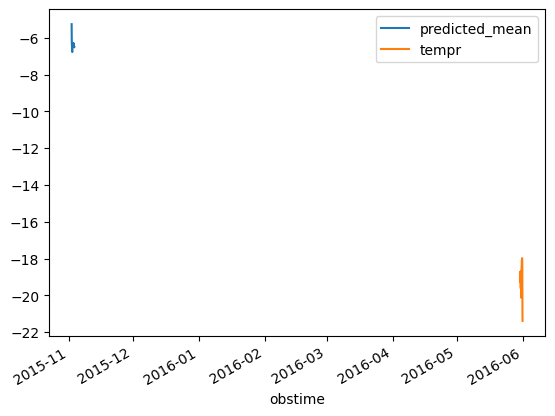

In [40]:
pred.plot(legend=True)
test['tempr'].plot(legend=True)

In [41]:
test['tempr'].mean()

-19.003

In [42]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test['tempr'], pred))
print(rmse)

12.651165524050063
